# Notes


In [63]:
import duckdb
import pandas as pd
import matplotlib.pyplot as plt
from graphviz import Digraph
from sympy.physics.units import magnetic_density

from variables import Variables as vars

plt.style.use('../../notebook.mplstyle')

In [64]:
# df = pd.read_parquet("./data/us_births.parquet")
con = duckdb.connect("./data/us_births.db")

### Annual births

Sum by year:

- `p_ds_lb_nt` - Estimated Down Syndrome live births without terminations (probabilities based on maternal age, sum is expected count)
- `p_ds_lb_wt` - Estimated Down Syndrome live births with terminations (probabilities based on annual estimates from surveillance data, sum is expected count)
- `down_ind` - Recorded Down Syndrome live births (1 = recorded, sum is count)

In [65]:
births_df = con.execute(
    """
    SELECT
        year, COUNT (*) AS lb, SUM (down_ind) AS down_ind, SUM (p_ds_lb_nt) AS p_ds_lb_nt, SUM (p_ds_lb_wt) AS p_ds_lb_wt
    FROM us_births
    WHERE year >= 1989 AND restatus <> 4
    GROUP BY year
    ORDER BY year
    """
).df().set_index(["year"])

births_df

,lb,down_ind,p_ds_lb_nt,p_ds_lb_wt
year,,,,
1989,4040958,1951.0,5429.126976,4194.514404
1990,4158212,1982.0,5710.019881,4386.913660
1991,4110907,1788.0,5788.420314,4427.446839
1992,4065014,1814.0,5881.707389,4402.410162
1993,4000240,1761.0,5951.395681,4372.262320
1994,3952767,1702.0,6056.822727,4355.949234
1995,3899589,1639.0,6135.353319,4371.439269
1996,3891494,1676.0,6273.630052,4276.751906
1997,3880894,1663.0,6390.771583,4362.124856


In [66]:
mage_df = con.execute(
    """
    SELECT
        year, CASE WHEN mage_c >= 35 THEN 1 ELSE 0
    END
    AS mage_gte_35,
        COUNT(*) AS lb,
        SUM(down_ind) AS down_ind,
        SUM(p_ds_lb_nt) AS p_ds_lb_nt,
        SUM(p_ds_lb_wt) AS p_ds_lb_wt
    FROM us_births
    WHERE year >= 1989 AND restatus <> 4
    GROUP BY year, mage_gte_35
    ORDER BY year, mage_gte_35
    """
).df().set_index(["year", "mage_gte_35"])

mage_df.unstack("mage_gte_35")

lb         down_ind           p_ds_lb_nt               \
mage_gte_35        0       1        0       1            0            1   
year                                                                      
1989         3701080  339878   1489.0   462.0  3370.256386  2058.870589   
1990         3790384  367828   1467.0   515.0  3470.512324  2239.507557   
1991         3726110  384797   1269.0   519.0  3420.079927  2368.340387   
1992         3662660  402354   1297.0   517.0  3384.362090  2497.345298   
1993         3581787  418453   1192.0   569.0  3329.221273  2622.174408   
1994         3515150  437617   1135.0   567.0  3284.245915  2772.576812   
1995         3445867  453722   1038.0   601.0  3235.774927  2899.578392   
1996         3417135  474359   1025.0   651.0  3216.566300  3057.063752   
1997         3391623  489271   1008.0   655.0  3195.788331  3194.983252   
1998         3431854  509699    979.0   702.0  3231.120620  3361.200726   
1999         3437685  521732    944.0   811.0  3233.636781  3459.288498   
2000         3512140  546674   1038.0   825.0  3308.806239  3667.455220   
2001         3476314  549619    992.0   811.0  3287.358150  3740.448820   
2002         3466524  555202   1010.0   840.0  3293.768391  3821.920622   
2003         3515458  574492   1010.0   871.0  3362.843203  3980.464157   
2004         3526645  585407   1049.0   897.0  3375.130018  4053.335751   
2005         3543986  594358   1074.0   931.0  3375.792309  4105.381500   
2006         3654426  611129   1139.0   947.0  3448.715855  4203.625438   
2007         3703787  612446   1098.0   948.0  3489.439041  4244.916153   
2008         3645196  602498   1053.0   956.0  3441.135197  4244.212088   
2009         3542846  587819   1087.0   907.0  3366.611291  4183.980420   
2010         3419746  579640   1039.0   883.0  3281.462794  4142.490251   
2011         3373211  580379    989.0   884.0  3271.320424  4139.135676   
2012         3363187  589654    984.0   941.0  3285.875473  4197.008010   
2013         3330652  601529   1096.0   894.0  3286.932256  4262.152247   
2014         3360864  627212   1002.0   976.0  3354.051879  4396.971265   
2015         3329728  648769   1063.0   994.0  3347.431284  4516.901270   
2016         3276204  669671   1078.0  1086.0  3326.625318  4626.900426   
2017         3176568  678932    996.0  1043.0  3241.963011  4702.985450   
2018         3097953  693732    978.0  1128.0  3184.760432  4812.987714   
2019         3045160  702353    950.0  1074.0  3147.000884  4901.990356   
2020         2919789  693858    937.0  1017.0  3035.850617  4852.959860   
2021         2936378  727914    883.0  1018.0  3086.777378  5079.197116   
2022         2916503  751255    848.0  1009.0  3079.947225  5322.897307   
2023         2844332  751685    826.0  1029.0  3014.497120  5351.321783   
2024         2854026  774908    843.0  1040.0  3038.813938  5528.192082   

              p_ds_lb_wt               
mage_gte_35            0            1  
year                                   
1989         3841.721040   352.793364  
1990         3998.855120   388.058540  
1991         4013.020470   414.426369  
1992         3966.660780   435.749382  
1993         3914.893191   457.369129  
1994         3873.695300   482.253934  
1995         3862.816907   508.622362  
1996         3755.431365   521.320541  
1997         3812.184252   549.940604  
1998         3898.586144   579.018064  
1999         3963.650805   601.556996  
2000         4035.448860   628.128426  
2001         4098.574206   648.000801  
2002         4215.293184   675.125632  
2003         4285.343302   700.305748  
2004         4295.453610   713.025726  
2005         4380.366696   734.626488  
2006         4546.105944   760.244476  
2007         4670.475407   772.294406  
2008         4582.011372   757.339986  
2009         4471.071652   741.827578  
2010         4254.164024   721.072160  
2011         4283.977970   737.081330  
2012         4254.431555   745.912310  
2013        

In [106]:
births_df = con.execute(
    """
    SELECT mracehisp,
           COUNT(*)        AS lb,
           SUM(down_ind)   AS down_ind,
           AVG(down_ind)   AS p_down_ind,
           AVG(p_ds_lb_nt) AS p_ds_lb_nt,
           AVG(p_ds_lb_wt) AS p_ds_lb_wt
    FROM us_births
    WHERE year >= 2003 AND restatus <> 4
    GROUP BY mracehisp
    ORDER BY mracehisp
    """
).df()

mean_prev_ds = con.execute(
    """
    SELECT AVG(p_ds_lb_wt) AS p_ds_lb_wt
    FROM us_births
    WHERE year >= 2003 AND restatus <> 4
    """
).df()["p_ds_lb_wt"].get(0)

mean_prev_rec = con.execute(
    """
    SELECT AVG(down_ind) AS down_ind
    FROM us_births
    WHERE year >= 2003 AND restatus <> 4
    """
).df()["down_ind"].get(0)

births_df["mracehisp"] = (
    births_df["mracehisp"]
    .fillna(9)  # replace pd.NA / NaN with 8
    .astype("UInt8")  # nullable integer type
    .map({
        1: "Non-Hispanic White",
        2: "Non-Hispanic Black",
        3: "Non-Hispanic American Indian/Alaska Native",
        4: "Non-Hispanic Asian",
        5: "Non-Hispanic Native Hawaiian or Other Pacific Islander",
        6: "Non-Hispanic more than one race",
        7: "Hispanic",
        8: "Origin unknown or not stated",
        9: "NA",
    })
)

births_df

,mracehisp,lb,down_ind,p_down_ind,p_ds_lb_nt,p_ds_lb_wt
0,Non-Hispanic White,28233067,15127.0,0.000594,0.001989,0.001299
1,Non-Hispanic Black,6570470,2666.0,0.000428,0.001944,0.001308
2,Non-Hispanic American Indian/Alaska Native,494297,275.0,0.000605,0.001819,0.001291
3,Non-Hispanic Asian,4160694,1533.0,0.000449,0.002634,0.001290
4,Non-Hispanic Native Hawaiian or Other Pacific ...,1183242,471.0,0.000491,0.001575,0.001262
5,Non-Hispanic more than one race,25494724,13957.0,0.000968,0.001928,0.001253
6,Hispanic,16549954,7912.0,0.000589,0.001840,0.001290
7,Origin unknown or not stated,3401087,1324.0,0.000659,0.002396,0.001259
8,NA,528750,230.0,0.001162,0.002454,0.001265


([0, 1, 2, 3, 4, 5, 6, 7, 8],
 [Text(0, 0, 'Non-Hispanic White'),
  Text(1, 0, 'Non-Hispanic Black'),
  Text(2, 0, 'Non-Hispanic American Indian/Alaska Native'),
  Text(3, 0, 'Non-Hispanic Asian'),
  Text(4, 0, 'Non-Hispanic Native Hawaiian or Other Pacific Islander'),
  Text(5, 0, 'Non-Hispanic more than one race'),
  Text(6, 0, 'Hispanic'),
  Text(7, 0, 'Origin unknown or not stated'),
  Text(8, 0, 'NA')])

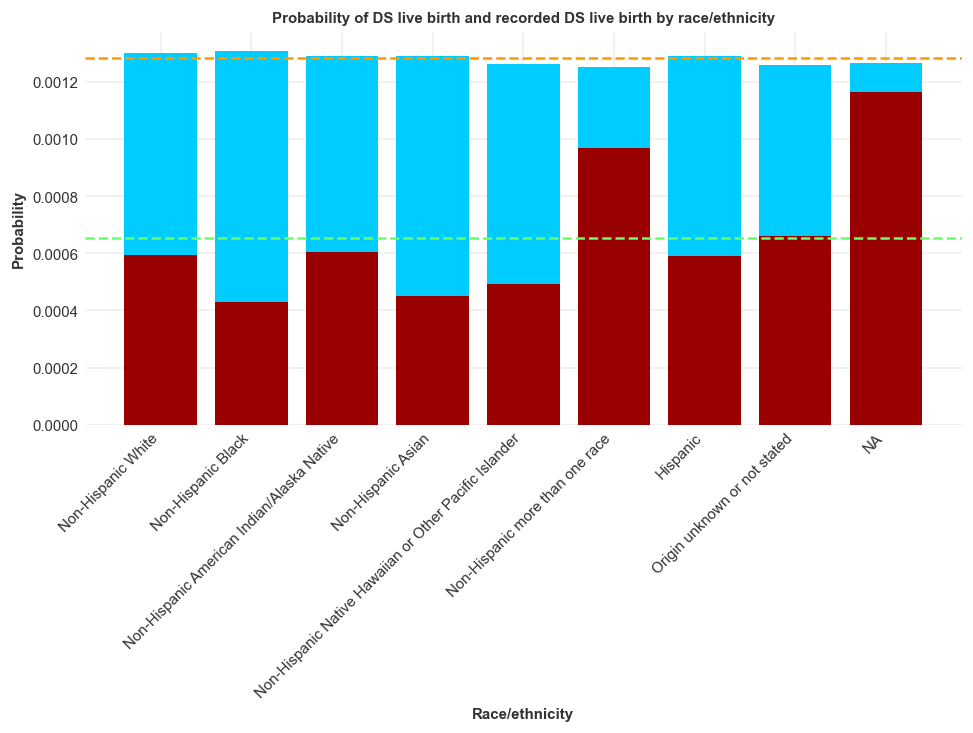

In [107]:
plt.figure(figsize=(8, 6))
plt.title("Probability of DS live birth and recorded DS live birth by race/ethnicity")
plt.xlabel("Race/ethnicity")
plt.ylabel("Probability")
plt.bar(births_df["mracehisp"], births_df["p_ds_lb_wt"], color="#00ccff")
plt.bar(births_df["mracehisp"], births_df["p_down_ind"], color="#990000")
# plot line for mean_prev_ds
plt.axhline(y=mean_prev_ds, color="#ff9900", linestyle="--", label="Mean estimated DS live births")
plt.axhline(y=mean_prev_rec, color="#66ff66", linestyle="--", label="Mean recorded DS live births")
# rotate x axis labels
plt.xticks(rotation=45, ha='right')


### Estimate prevalence given year and ethnicity

In [163]:
eth_prev_df = con.execute(
    """
    SELECT
        year, mracehisp, down_ind, p_ds_lb_nt, p_ds_lb_wt
    FROM us_births
    WHERE year >= 2003 AND year <= 2023
    """
).df().convert_dtypes()

eth_prev_df

,year,mracehisp,down_ind,p_ds_lb_nt,p_ds_lb_wt
0,2003,6,<NA>,0.000746,0.001219
1,2003,6,<NA>,0.000684,0.001219
2,2003,<NA>,<NA>,0.000664,0.001219
3,2003,8,<NA>,0.000723,0.001219
4,2003,6,<NA>,0.001219,0.001219
...,...,...,...,...,...
83158418,2023,8,<NA>,0.002192,0.001324
83158419,2023,7,0,0.000956,0.001324
83158420,2023,7,0,0.003738,0.001324
83158421,2023,1,0,0.00283,0.001324


In [197]:
eth_ds_chance_df = pd.read_csv("./us-births-estimated-prevalence-ethnicity-2000-2023.csv").convert_dtypes()
eth_ds_chance_df.set_index(["year", "ethnicity"], inplace=True)
eth_ds_chance_df = eth_ds_chance_df.unstack("ethnicity")
eth_ds_chance_df

prevalence             \
ethnicity American Indian or Alaska Native   Hispanic   
year                                                    
2000                              7.624409  11.964842   
2001                              7.280862  12.598719   
2002                             11.570306  13.113249   
2003                             11.764376  12.983983   
2004                             10.927699  13.242371   
2005                              10.48321  13.153154   
2006                             10.425905  13.484204   
2007                             11.318638  13.415931   
2008                             11.708285  12.356754   
2009                             11.795845  13.905016   
2010                             12.114231  14.544928   
2011                             12.598796  14.857595   
2012                             13.609832   15.30731   
2013                             14.714737  15.607811   
2014                             13.912633  16.200423   
2015                                  <NA>       <NA>   
2016                             10.741986  15.996046   
2017                                  <NA>       <NA>   
2018                             13.052782   16.76941   
2019                                  <NA>       <NA>   
2020                                  <NA>       <NA>   
2021                                  <NA>       <NA>   
2022                                  <NA>       <NA>   
2023                                  <NA>       <NA>   
2024                                  <NA>       <NA>   

                                                                     \
ethnicity Non-Hispanic Asian or Pacific Islander Non-Hispanic Black   
year                                                                  
2000                                    9.429186          10.499449   
2001                                    9.882583          10.771309   
2002                                   10.149234          11.488153   
2003                                   10.363935          11.255914   
2004                                    9.731245          11.582299   
2005                                    9.810701          12.008868   
2006                                    8.802434          12.098491   
2007                                    9.280463          12.004018   
2008                                    9.655644          11.978613   
2009                                    9.770403          11.891816   
2010                                    9.664683          11.598217   
2011                                   10.787258           11.28257   
2012                                   10.789827          11.452283   
2013                                   11.617068          11.870662   
2014                                    10.08654          12.418696   
2015                                        <NA>               <NA>   
2016                                    9.100725           12.42453   
2017                                        <NA>               <NA>   
2018                                    8.871391          13.171963   
2019                                        <NA>               <NA>   
2020                                        <NA>               <NA>   
2021                                        <NA>               <NA>   
2022                                        <NA>               <NA>   
2023                                        <NA>               <NA>   
2024                                        <NA>               <NA>   

                              
ethnicity Non-Hispanic White  
year                          
2000               12.128999  
2001               12.323849  
2002               12.776885  
2003               12.774354  
2004               12.695665  
2005               12.986991  
2006               12.744387  
2007               12.840502  
2008               13.070989  
2009               12.636149  
2010               12.215485  
2011        

In [198]:
for i in range(0,5):
    col = eth_ds_chance_df.columns[i]
    eth_ds_chance_df[col] = eth_ds_chance_df[col].fillna(
        eth_ds_chance_df[col].rolling(window=10, min_periods=1).mean()) / 10000
eth_ds_chance_df

prevalence            \
ethnicity American Indian or Alaska Native  Hispanic   
year                                                   
2000                              0.000762  0.001196   
2001                              0.000728   0.00126   
2002                              0.001157  0.001311   
2003                              0.001176  0.001298   
2004                              0.001093  0.001324   
2005                              0.001048  0.001315   
2006                              0.001043  0.001348   
2007                              0.001132  0.001342   
2008                              0.001171  0.001236   
2009                               0.00118  0.001391   
2010                              0.001211  0.001454   
2011                               0.00126  0.001486   
2012                              0.001361  0.001531   
2013                              0.001471  0.001561   
2014                              0.001391   0.00162   
2015                              0.001247  0.001441   
2016                              0.001074    0.0016   
2017                              0.001265  0.001485   
2018                              0.001305  0.001677   
2019                              0.001296  0.001561   
2020                              0.001311  0.001579   
2021                              0.001321  0.001598   
2022                              0.001311  0.001614   
2023                              0.001257  0.001632   
2024                               0.00119  0.001638   

                                                                     \
ethnicity Non-Hispanic Asian or Pacific Islander Non-Hispanic Black   
year                                                                  
2000                                    0.000943            0.00105   
2001                                    0.000988           0.001077   
2002                                    0.001015           0.001149   
2003                                    0.001036           0.001126   
2004                                    0.000973           0.001158   
2005                                    0.000981           0.001201   
2006                                     0.00088            0.00121   
2007                                    0.000928             0.0012   
2008                                    0.000966           0.001198   
2009                                    0.000977           0.001189   
2010                                    0.000966            0.00116   
2011                                    0.001079           0.001128   
2012                                    0.001079           0.001145   
2013                                    0.001162           0.001187   
2014                                    0.001009           0.001242   
2015                                    0.001005           0.001184   
2016                                     0.00091           0.001242   
2017                                    0.001018           0.001186   
2018                                    0.000887           0.001317   
2019                                    0.001013           0.001203   
2020                                    0.001021            0.00121   
2021                                    0.001009           0.001227   
2022                                    0.000992           0.001247   
2023                                    0.000935           0.001267   
2024                                    0.000899            0.00128   

                              
ethnicity Non-Hispanic White  
year                          
2000                0.001213  
2001                0.001232  
2002                0.001278  
2003                0.001277  
2004                 0.00127  
2005                0.001299  
2006                0.001274  
2007                0.001284  
2008                0.001307  
2009                0.001264  
2010                0.001222  
2011                0.001227  
2012     

In [202]:
eth_ds_chance_df.index

Index([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011,
       2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023,
       2024],
      dtype='Int64', name='year')

In [206]:
lookup = eth_ds_chance_df.copy()
lookup.columns = eth_ds_chance_df.columns.droplevel(0)
lookup.columns = [col.replace("\n", "_") for col in lookup.columns]
lookup = lookup.reset_index().melt(id_vars="year", var_name="label", value_name="rate").set_index("year")
lookup

,label,rate
year,,
2000,American Indian or Alaska Native,0.000762
2001,American Indian or Alaska Native,0.000728
2002,American Indian or Alaska Native,0.001157
2003,American Indian or Alaska Native,0.001176
2004,American Indian or Alaska Native,0.001093
...,...,...
2020,Non-Hispanic White,0.001247
2021,Non-Hispanic White,0.001251
2022,Non-Hispanic White,0.001258


In [171]:
mracehisp_to_label = {
    1: "Non-Hispanic White",
    2: "Non-Hispanic Black",
    3: "American Indian or Alaska Native",
    4: "Non-Hispanic Asian or Pacific Islander",
    5: "Non-Hispanic Asian or Pacific Islander",
    6: "Non-Hispanic_more_than_one",
    7: "Hispanic",
}
eth_prev_df["label"] = eth_prev_df["mracehisp"].map(mracehisp_to_label)

,year,mracehisp,down_ind,p_ds_lb_nt,p_ds_lb_wt,ethnicity
0,2003,6,<NA>,0.000746,0.001219,NaN
1,2003,6,<NA>,0.000684,0.001219,NaN
2,2003,<NA>,<NA>,0.000664,0.001219,NaN
3,2003,8,<NA>,0.000723,0.001219,NaN
4,2003,6,<NA>,0.001219,0.001219,NaN
...,...,...,...,...,...,...
83158418,2023,8,<NA>,0.002192,0.001324,NaN
83158419,2023,7,0,0.000956,0.001324,Hispanic
83158420,2023,7,0,0.003738,0.001324,Hispanic
83158421,2023,1,0,0.00283,0.001324,Non-Hispanic White


In [62]:
eth_prev_df["p_ds_lb_nt_eth"] = eth_prev_df.apply(
    lambda row: eth_ds_chance_df.loc[(row["year"], row["mracehisp"]), "p_ds_lb_wt_eth"] if row["mracehisp"] != 5 else 0,
)
eth_prev_df

KeyError: (np.float64(2003.0), <NA>)

In [ ]:
plt.figure(figsize=(12, 5))
plt.title("Estimated vs recorded annual DS live births")
plt.xlabel("Year")
plt.ylabel("Estimate/count")
plt.bar(mage_df.index, mage_df[vars.P_DS_LB_NT], label="DS live births absent terminations")
plt.bar(mage_df.index, mage_df[vars.P_DS_LB_WT], label="DS live births")
plt.plot(mage_df.index, mage_df[vars.DOWN_IND], marker='o', color="#ff9060", label='Recorded DS live births')
plt.legend()

In [ ]:
age_ds_df = df[[vars.MAGE_C, vars.P_DS_LB_NT, vars.P_DS_LB_WT]].groupby(vars.MAGE_C).describe()
age_ds_df

In [ ]:
recorded_df = df[df[vars.DOWN_IND] == 1]

In [ ]:
age_ds_recorded_df = recorded_df[[vars.MAGE_C, vars.P_DS_LB_NT, vars.P_DS_LB_WT]].groupby(vars.MAGE_C).describe()
age_ds_recorded_df

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(age_ds_recorded_df.index, age_ds_recorded_df[(vars.P_DS_LB_WT, 'mean')], color="#99ccff",
         label="Chance of DS live birth (recorded)")
plt.plot(age_ds_df.index, age_ds_df[(vars.P_DS_LB_WT, 'mean')], color="#99d066", label="Chance of DS live birth (all)")
plt.legend()

In [ ]:
fig, axs = plt.subplots(1, 2, sharex=True, figsize=(12, 6))

axs[0].set_title("Recorded DS births")
axs[0].bar(age_ds_recorded_df.index, age_ds_recorded_df[(vars.P_DS_LB_NT, 'count')], color="#99ccff")

axs[1].set_title("DS births (all, estimated given maternal age)")
axs[1].bar(age_ds_df.index, age_ds_df[(vars.P_DS_LB_NT, 'count')], color="#99d066")


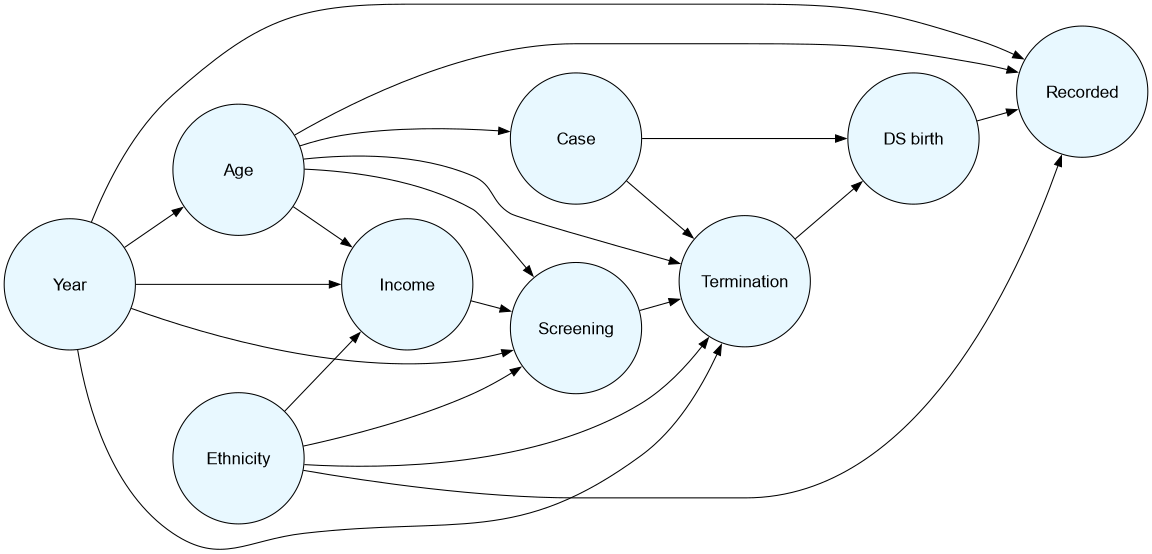

In [50]:
from graphviz import Digraph

dag = Digraph()

dag.attr(fontname="Helvetica")
dag.attr("node", fontname="Helvetica")
dag.attr("edge", fontname="Helvetica")

# set font sizes
dag.attr(size="12,12")
dag.attr("node", fontsize="16", style="filled", fillcolor="#e8f8ff")
dag.attr("edge", fontsize="16")

dag.attr(rankdir="LR", splines="spline")  # Top-to-bottom flow
dag.attr("node", shape="circle", fixedsize="true", width="1.75")

edges = [
    ('Age', 'Case'),
    ('Age', 'Screening'),
    ('Age', 'Termination'),
    ('Age', 'Income'),
    ('Age', 'Recorded'),
    ('Year', 'Age'),
    ('Year', 'Screening'),
    ('Year', 'Termination'),
    ('Year', 'Income'),
    ('Year', 'Recorded'),
    ('Ethnicity', 'Income'),
    ('Ethnicity', 'Screening'),
    ('Ethnicity', 'Termination'),
    ('Ethnicity', 'Recorded'),
    ('Income', 'Screening'),
    ('Case', 'Termination'),
    ('Case', 'DS birth'),
    ('Screening', 'Termination'),
    ('Termination', 'DS birth'),
    ('DS birth', 'Recorded'),
]

for src, dst in edges:
    dag.edge(src, dst)

from IPython import display

display.display_png(dag)
